# MLOps exercises

In [6]:
#pip install seaborn

In [8]:
#pip install mlflow

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn

import tempfile

from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.metrics import  mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

## Execise 1

In this exercise, do the following:
1. Create a function that preprocess new ames data in the same way as the original ames data was preprocessed in step 5 in the `MLOps.ipynb` notebook.
2. Create a function that takes as input a new ames dataset and a model. The function should pre-process the new data and evaluate the model on that new data using mean absolute error.
3. Test the function from 2. on the "NewAmesData1.csv" dataset and the best model from the `MLOps.ipynb` notebook.
4. Test the function from 2. on the "NewAmesData2.csv" dataset and the best model from the `MLOps.ipynb` notebook. Do you see any drift?
5. Do you see a data drift in "NewAmesData2.csv"? If so, for which variables?
6. Do you see a data drift in "NewAmesData4.csv"? If so, for which variables?
7. Create a function that retrain a model on the new data as well as the old training data
8. Retrain the `model_final` on the new data "NewAmesData1.csv" as well as the old training data, using the function from 5. Then test the new model on the old testset.
9. Split the "NewAmesData2.csv" dataset into a train and test set. Train  the best model from the `MLOps.ipynb` notebook on the training part and test it on the test part. Did you get a better model? Now combine your new training data with the original training data and retrain the model on that. Did that give you a better model?

### 1. Create a function that preprocess new ames data in the same way as the original ames data was preprocessed in step 5 in the MLOps.ipynb notebook.

In [10]:
# extract
def extract(file):
    return pd.read_csv("../Notebooks and data-12/Data/" + file)

# transform
def pre_process(df):
    df = df.copy()
    new_ames = df.join(pd.get_dummies(df["Bldg Type"], drop_first=True, dtype = "int", prefix="BType"))
    new_ames = df.join(pd.get_dummies(new_ames["Neighborhood"], drop_first=True, dtype = "int", prefix="Nbh"))
    new_ames = df.drop(columns = ["Bldg Type", "Neighborhood"])

    return new_ames

### 2. Create a function that takes as input a new ames dataset and a model. The function should pre-process the new data and evaluate the model on that new data using mean absolute error.

In [17]:
#!pip freeze > requirements.txt ## IMPORTANT

#pip install -r /path/to/requirements.txt

In [32]:
mlflow.set_experiment("MLFlow Housing data Example")

results = []

def evaluate_model(model, model_name, data):

    data = pre_process(data)
    with mlflow.start_run():
        X_ames = data.drop(columns=["SalePrice"])
        y_ames = data.SalePrice
        X_train, X_test, y_train, y_test = train_test_split(X_ames, y_ames, test_size=0.2, random_state=42)
    
        # Log feature combination and model type
        mlflow.log_param("features", data.columns)
        mlflow.log_param("model_type", model)
        
        model.fit(X_train, y_train)
        y_test_predictions = model.predict(X_test)       
    
        MAE = mean_absolute_error(y_test, y_test_predictions)

        # Log metrics
        mlflow.log_metric("MAE", MAE)

        # Create and log a plot of the metrics,    the plot should be showing the prediction vs actual for the test
        fig, ax = plt.rcParams['figure.figsize'] = [8, 8]
        ames = X_test
        ames["SalePrice"] = y_test
        ames.hist()
        
        # Save the plot to a temporary file and log it as an artifact
        temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="plots")
        temp_file.close()

       # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        # Store results for summary
        results.append({
            "MAE": MAE,
            "model": model_name,
        })
        
# Print summary of results
results_df = pd.DataFrame(results)
print("\nSummary of Experiment Results:")
print(results_df)


Summary of Experiment Results:
Empty DataFrame
Columns: []
Index: []


### 3. Test the function from 2. on the "NewAmesData1.csv" dataset and the best model from the MLOps.ipynb notebook.

In [12]:
data0 = extract("AmesHousing.csv")
data1 = extract("NewAmesData1.csv")
data2 = extract("NewAmesData2.csv")
data4 = extract("NewAmesData4.csv")

In [13]:
model_gb_1000 = GradientBoostingRegressor(n_estimators=1000)

2025/02/28 10:37:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


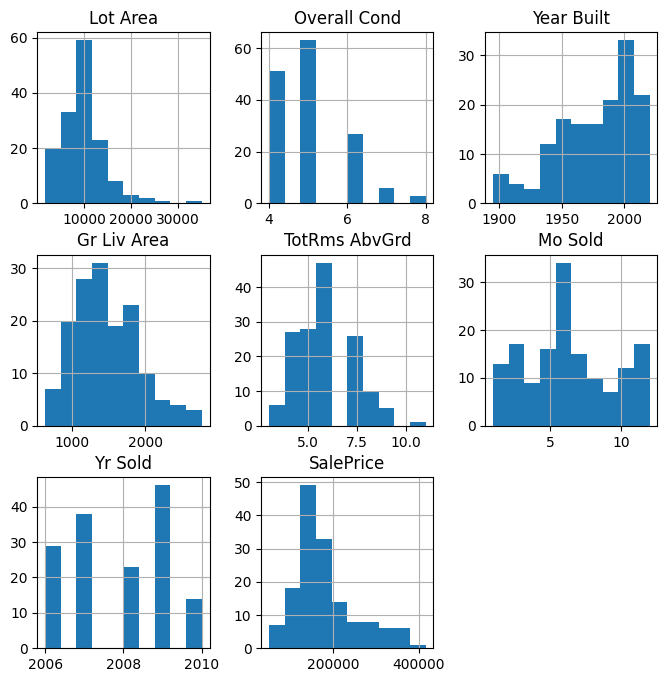

In [33]:
evaluate_model(model_gb_1000, "gradient boosting regressor", data1)

### 4. Test the function from 2. on the "NewAmesData2.csv" dataset and the best model from the MLOps.ipynb notebook. Do you see any drift?

2025/02/28 10:37:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


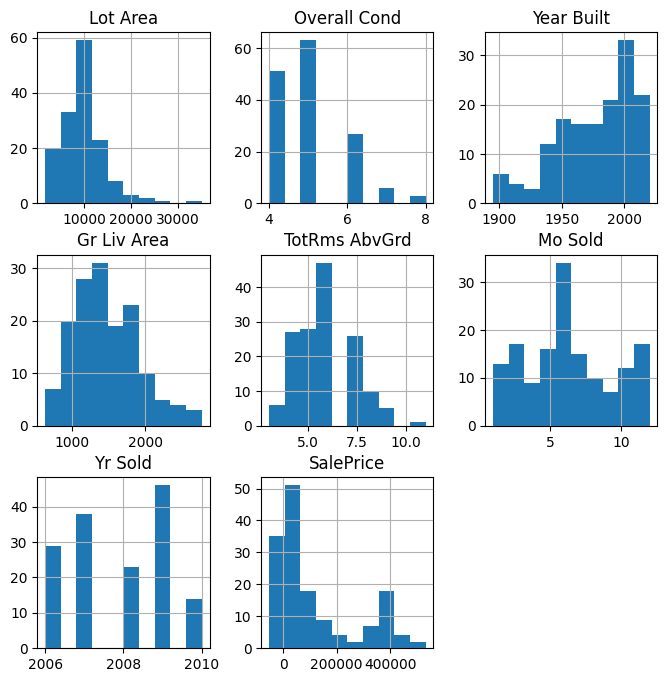

In [34]:
evaluate_model(model_gb_1000, "gradient boosting regressor", data2)

### 5. Do you see a data drift in "NewAmesData2.csv"? If so, for which variables?

In [30]:
data1

,Lot Area,Overall Cond,Year Built,Gr Liv Area,TotRms AbvGrd,Mo Sold,Yr Sold,Bldg Type,Neighborhood,SalePrice
0,10738,6,1954,1457,5,8,2009,1Fam,NAmes,132661
1,13835,4,1989,1792,6,3,2006,1Fam,NridgHt,372144
2,9667,5,1997,1103,6,5,2010,1Fam,SawyerW,150786
3,10699,6,2000,1671,6,4,2009,1Fam,CollgCr,211081
4,14033,4,1992,1357,5,10,2009,1Fam,Mitchel,142802
...,...,...,...,...,...,...,...,...,...,...
744,8944,5,1994,1947,7,12,2007,1Fam,Somerst,271926
745,11099,5,2014,1706,6,7,2009,1Fam,NridgHt,254630
746,6271,5,1928,1373,6,11,2007,1Fam,BrkSide,127650
747,10375,4,1980,1295,5,7,2009,1Fam,Mitchel,130559


In [31]:
data2

,Lot Area,Overall Cond,Year Built,Gr Liv Area,TotRms AbvGrd,Mo Sold,Yr Sold,Bldg Type,Neighborhood,SalePrice
0,10738,6,1954,1457,5,8,2009,1Fam,NAmes,-9790.3818
1,13835,4,1989,1792,6,3,2006,1Fam,NridgHt,286779.5056
2,9667,5,1997,1103,6,5,2010,1Fam,SawyerW,5021.1738
3,10699,6,2000,1671,6,4,2009,1Fam,CollgCr,414742.1677
4,14033,4,1992,1357,5,10,2009,1Fam,Mitchel,-57592.0466
...,...,...,...,...,...,...,...,...,...,...
744,8944,5,1994,1947,7,12,2007,1Fam,Somerst,458212.1152
745,11099,5,2014,1706,6,7,2009,1Fam,NridgHt,401512.8926
746,6271,5,1928,1373,6,11,2007,1Fam,BrkSide,47600.6850
747,10375,4,1980,1295,5,7,2009,1Fam,Mitchel,-4895.9625


    The data for both are completely the same and have the same shape, so no drift

### 6. Do you see a data drift in "NewAmesData4.csv"? If so, for which variables?

2025/02/28 10:38:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


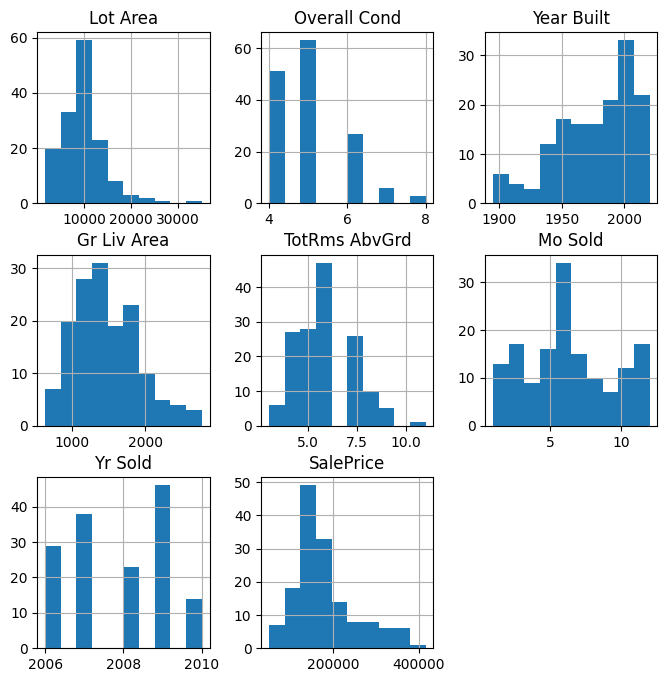

In [36]:
evaluate_model(model_gb_1000, "gradient boosting regressor", data1)

2025/02/28 10:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


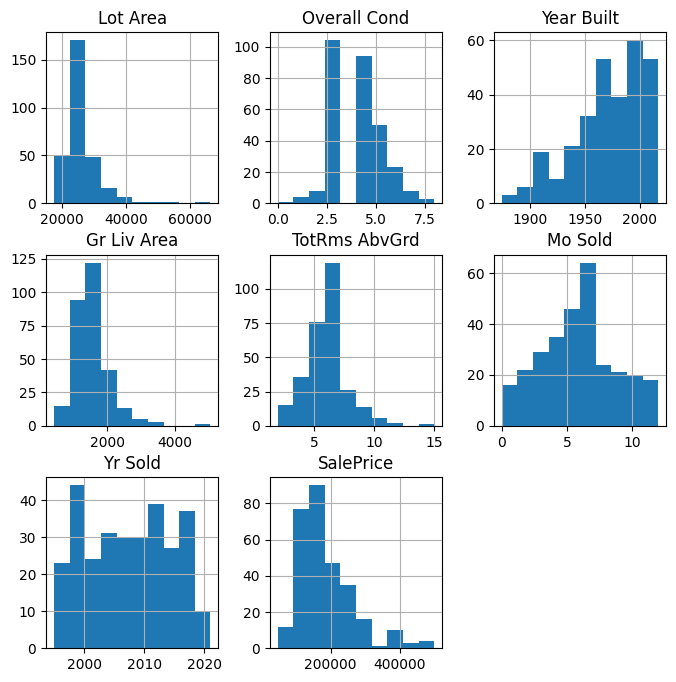

In [35]:
evaluate_model(model_gb_1000, "gradient boosting regressor", data4)